### Analysis plots

In [59]:
%matplotlib widget
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import movement as mv
from movement.io import load_poses
from pathlib import Path
import xarray as xr
import ocplot as ocp  # optional dependency for adding plot features, to be installed from 

from matplotlib.colors import LinearSegmentedColormap, Normalize


def get_concatenated_cmap(main_cmap="viridis_r", main_range=(0, 1), 
                          below_thr_cmap="Reds_r", below_thr_range=(0, 0.5),
                          threshold=0.2):
    NCOLS = 1280
    
    cmap1, cmap2 = plt.get_cmap(main_cmap), plt.get_cmap(below_thr_cmap)

    # Define the colors and positions to combine the colormaps
    colors1 = cmap1(np.linspace(0., 1, NCOLS))
    colors2 = cmap2(np.linspace(0., 0.5, int(NCOLS / ((1 / threshold) - 1))))

    # Create a new concatenated colormap
    return LinearSegmentedColormap.from_list('concatenated_cmap', np.vstack((colors2,colors1)))


In [2]:
main_data_path = Path("/Users/vigji/Desktop/dest_dir")
example_dir = main_data_path / "19042024" / "M8"

In [34]:
def load_multi_view_folder(folder_path, view_names=["top", "bottom", "left", "right", "central"], concat=True):
    """Load all the views from a folder and concatenate them along a new dimension.
    Assumes a folder contains a single set of views; if there's multiple ones, only the first is loaded.
    """
    path_dict = {pattern: next(folder_path.rglob(f"*{pattern}*.h5")) for pattern in view_names}
    return load_multi_view_dict(path_dict, concat=concat)


def load_multi_view_dict(files_dict, concat=True):
    # Create a DataArray for the new coordinate
    print(files_dict.keys())
    new_coord_camera = xr.DataArray(list(files_dict.keys()), dims='view')

    dlc_data_dict = [load_poses.from_dlc_file(f, fps=60) for f in files_dict.values()]
    
    if concat:
        return xr.concat(dlc_data_dict, dim=new_coord_camera)
    else:
        return dlc_data_dict


In [19]:
loaded_data = load_multi_view_folder(example_dir)
loaded_data.dims

dict_keys(['top', 'bottom', 'left', 'right', 'central'])


FrozenMappingWarningOnValuesAccess({'view': 5, 'time': 121798, 'individuals': 1, 'keypoints': 10, 'space': 2})

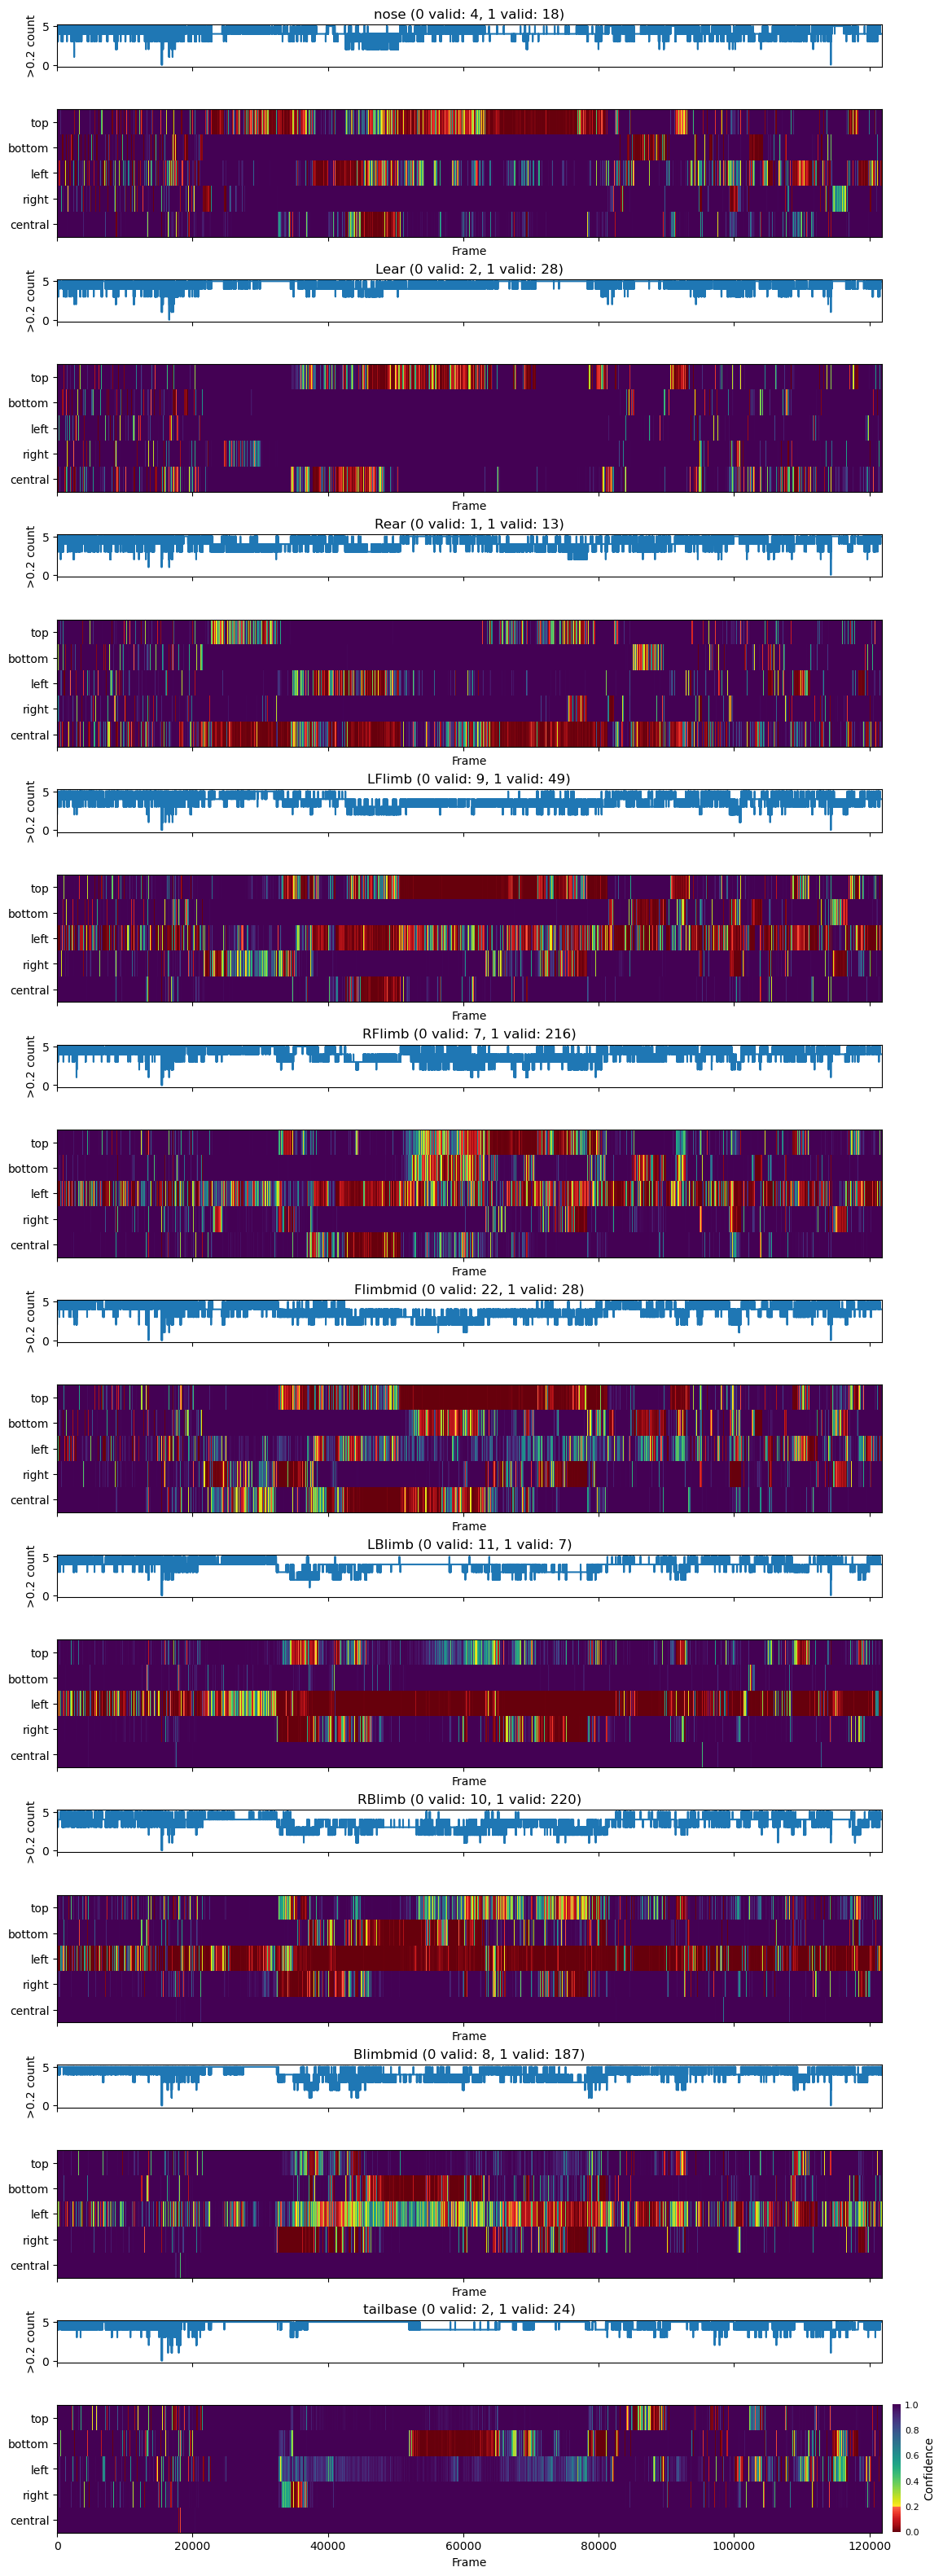

In [20]:
THR = 0.2
concatenated_cmap = get_concatenated_cmap()

confidence_data = loaded_data["confidence"]
view_labels = confidence_data.coords["view"].values
keypoints = confidence_data.coords["keypoints"].values

f, axs = plt.subplots(2*len(keypoints), 1, figsize=(15, 4*len(keypoints)), sharex=True, 
                      gridspec_kw={"height_ratios": [1, 3]*len(keypoints), "right": 0.8, "hspace": 0.5})

for i_kp, kp in enumerate(keypoints):
    nose_data = confidence_data.sel(keypoints=kp)
    valid_kp_count = np.sum(nose_data.values > THR, axis=0)
    axs[i_kp*2].plot(valid_kp_count)
    im = axs[i_kp*2+1].imshow(nose_data, interpolation="none", aspect="auto", cmap=concatenated_cmap)
    axs[i_kp*2+1].set_yticks(np.arange(len(view_labels)))
    axs[i_kp*2+1].set_yticklabels(view_labels)
    axs[i_kp*2+1].set_xlabel("Frame")
    axs[i_kp*2].set_ylabel(">0.2 count")

    zero_count = np.sum(valid_kp_count == 0)
    one_count = np.sum(valid_kp_count == 1)
    axs[i_kp*2].set_title(f"{kp.item()} (0 valid: {zero_count}, 1 valid: {one_count})")


ocp.add_cbar(im, axs[-1], label="Confidence", inset_loc=(1.02, 0.05, 0.01, 1), ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])

f.savefig(example_dir / "confidence_maps.png", dpi=300, bbox_inches="tight")

## Keypoint jumps and confidence

In [38]:
loaded_data_list = load_multi_view_folder(example_dir, concat=False)
single_view_data = loaded_data_list[0]

dict_keys(['top', 'bottom', 'left', 'right', 'central'])


In [72]:
disp = single_view_data.move.compute_displacement()
conf = single_view_data.confidence

<xarray.DataArray 'position' (time: 121798, individuals: 1)> Size: 974kB
0.0 0.8307 0.3048 16.47 5.257 4.207 ... 0.03673 0.05672 0.03697 0.3279 0.002788
Coordinates:
  * time         (time) float64 974kB 0.0 0.01667 0.03333 ... 2.03e+03 2.03e+03
  * individuals  (individuals) <U12 48B 'individual_0'
    keypoints    <U8 32B 'nose'

/var/folders/wp/q156lfy924zg6bqc48v9j2800000gn/T/ipykernel_46964/3059739693.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axs = plt.subplots(len(keypoints) // 3+1, 3, figsize=(12, 1*len(keypoints)), sharex=True, sharey=True)


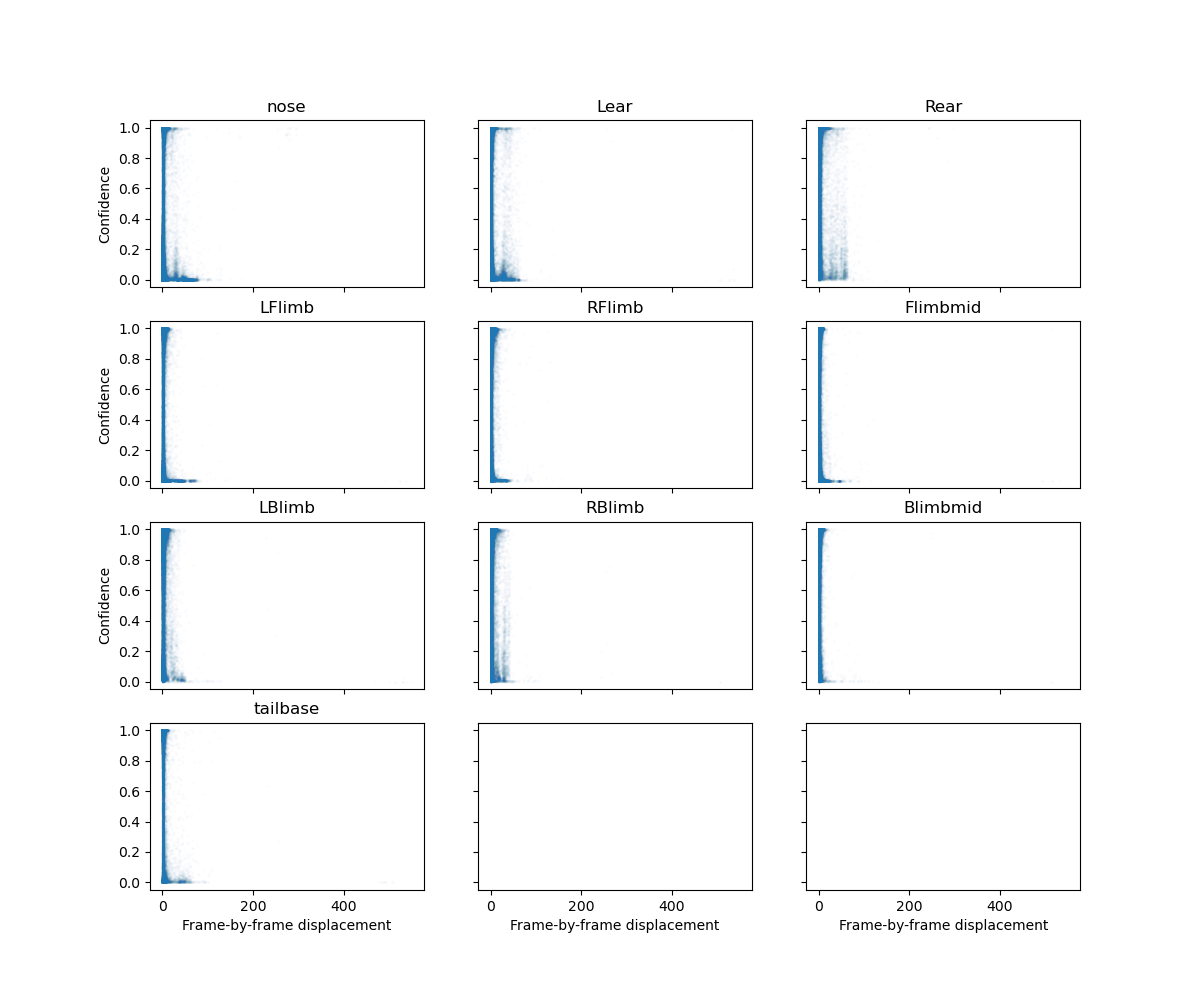

In [89]:
# make 3 columns panel for all keypoints
f, axs = plt.subplots(len(keypoints) // 3+1, 3, figsize=(12, 1*len(keypoints)), sharex=True, sharey=True)

for i_kp, kp in enumerate(keypoints):
    kp_trace = disp.sel(keypoints=kp)
    conf_trace = conf.sel(keypoints=kp)
    abs_disp = (kp_trace**2).sum("space")**(1/2)
    axs.flat[i_kp].scatter(abs_disp, conf_trace, s=2, alpha=0.01)
    axs.flat[i_kp].set_title(kp.item())

for i in range(3):
    axs[-1, i].set_xlabel("Frame-by-frame displacement")
    axs[i, 0].set_ylabel("Confidence")
